Features: 42, Mean PPV (1%): 0.5111111111111111
Features: 41, Mean PPV (1%): 0.5555555555555556
Features: 40, Mean PPV (1%): 0.6888888888888889
Features: 39, Mean PPV (1%): 0.6222222222222221
Features: 38, Mean PPV (1%): 0.48888888888888893
Features: 37, Mean PPV (1%): 0.5333333333333333
Features: 36, Mean PPV (1%): 0.5777777777777777
Features: 35, Mean PPV (1%): 0.6222222222222222
Features: 34, Mean PPV (1%): 0.6222222222222222
Features: 33, Mean PPV (1%): 0.6
Features: 32, Mean PPV (1%): 0.5999999999999999
Features: 31, Mean PPV (1%): 0.6444444444444444
Features: 30, Mean PPV (1%): 0.5777777777777778
Features: 29, Mean PPV (1%): 0.6888888888888889
Features: 28, Mean PPV (1%): 0.6666666666666666
Features: 27, Mean PPV (1%): 0.6666666666666666
Features: 26, Mean PPV (1%): 0.6666666666666666
Features: 25, Mean PPV (1%): 0.6666666666666666
Features: 24, Mean PPV (1%): 0.6666666666666667
Features: 23, Mean PPV (1%): 0.7999999999999999
Features: 22, Mean PPV (1%): 0.7555555555555554
Featur

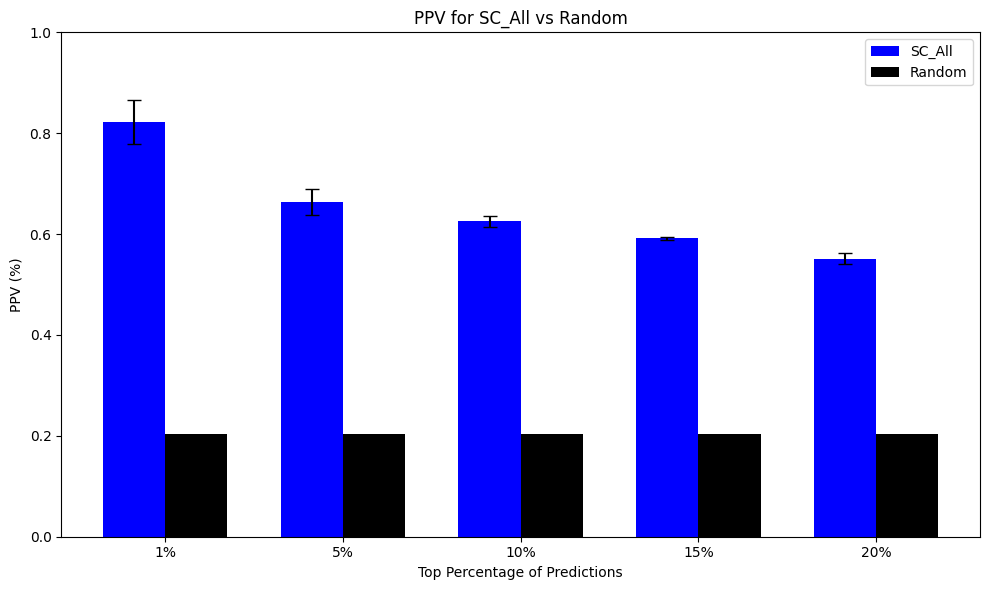

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
from scipy.stats import sem

# Function to calculate the PPV at top percentiles
def calculate_top_percentile_ppv(probabilities, true_labels, percentiles):
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_labels = true_labels[sorted_indices]
    ppv_percentiles = []

    for p in percentiles:
        n_top = int(len(sorted_labels) * (p / 100))
        if n_top == 0:
            ppv_percentiles.append(0)
        else:
            top_labels = sorted_labels[:n_top]
            ppv = np.sum(top_labels) / len(top_labels)  # Precision = TP / (TP + FP)
            ppv_percentiles.append(ppv)

    return ppv_percentiles

# Function to load discretized data
def load_discretized_data():
    file_path = './cerevisiae_data.xls'  # Replace with the correct path
    discretized_data = pd.read_excel(file_path, sheet_name='entropy discretized')

    columns_with_symbols = discretized_data.columns[2:]  # Skip 'Essential' and 'orf_id'
    label_encoders = {}

    for column in columns_with_symbols:
        le = LabelEncoder()
        discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
        label_encoders[column] = le

    return discretized_data.drop(columns=['Essential', 'orf_id']), discretized_data['Essential']

# Load data and ranking
X, y = load_discretized_data()
CMIM_ranking = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus', 
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias', 
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size', 
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP', 
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS', 
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG', 
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule', 
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']
X_ranked = X[CMIM_ranking]

# Percentiles for the PPV
percentiles = [1, 5, 10, 15, 20]
n_splits = 5  # Number of folds in StratifiedKFold
highest_ppv_1 = 0
optimal_features = None
ppv_scores_by_features = []

# Feature Selection with Cross-Validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
for i in range(len(CMIM_ranking), 0, -1):
    X_selected = X_ranked.iloc[:, :i]
    ppv_1_scores = []

    for train_index, test_index in kf.split(X_selected, y):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Oversampling the minority class
        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        X_train_oversampled, y_train_oversampled = resample(
            X_train_minority, y_train_minority,
            replace=True,
            n_samples=np.sum(y_train == 0),
            random_state=42
        )

        X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        # Calculate PPV at top 1%
        ppv_top = calculate_top_percentile_ppv(y_prob, y_test.to_numpy(), percentiles)
        ppv_1_scores.append(ppv_top[0])

    mean_ppv_1 = np.mean(ppv_1_scores)
    ppv_scores_by_features.append(mean_ppv_1)
    print(f"Features: {i}, Mean PPV (1%): {mean_ppv_1}")

    if mean_ppv_1 > highest_ppv_1:
        highest_ppv_1 = mean_ppv_1
        optimal_features = i

print("Highest PPV (1%):", highest_ppv_1)
print("Optimal number of features:", optimal_features)

# Final Evaluation
gene_probabilities_final = np.zeros(len(y))
X_optimal = X_ranked.iloc[:, :optimal_features]
final_ppv_scores = []

for train_index, test_index in kf.split(X_optimal, y):
    X_train, X_test = X_optimal.iloc[train_index], X_optimal.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Oversampling the minority class
    X_train_minority = X_train[y_train == 1]
    y_train_minority = y_train[y_train == 1]

    X_train_oversampled, y_train_oversampled = resample(
        X_train_minority, y_train_minority,
        replace=True,
        n_samples=np.sum(y_train == 0),
        random_state=42
    )

    X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
    y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

    nb_classifier = GaussianNB()
    nb_classifier.fit(X_train_balanced, y_train_balanced)
    y_prob = nb_classifier.predict_proba(X_test)[:, 1]

    ppv_top = calculate_top_percentile_ppv(y_prob, y_test.to_numpy(), percentiles)
    final_ppv_scores.append(ppv_top)

# Aggregate final results
final_ppv_means = np.mean(final_ppv_scores, axis=0)
final_ppv_sems = sem(final_ppv_scores, axis=0)
print("Final PPV Percentiles:", final_ppv_means)

# Plot final results with confidence intervals
fig, ax = plt.subplots(figsize=(10, 6))
random_ppv = [np.mean(y)] * len(percentiles)  # Baseline

width = 0.35
labels = [f'{p}%' for p in percentiles]
ax.bar(np.arange(len(percentiles)) - width/2, final_ppv_means, width, yerr=final_ppv_sems, label='SC_All', color='blue', capsize=5)
ax.bar(np.arange(len(percentiles)) + width/2, random_ppv, width, label='Random', color='black')

ax.set_xlabel('Top Percentage of Predictions')
ax.set_ylabel('PPV (%)')
ax.set_title('PPV for SC_All vs Random')
ax.set_xticks(np.arange(len(percentiles)))
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()
